In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

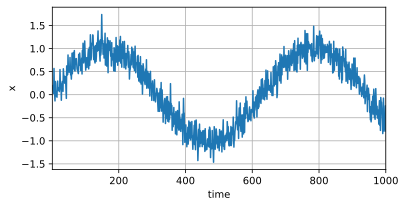

In [2]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [8]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

x[:25], features[:5], labels[:5]

(tensor([ 0.1378,  0.1207,  0.1990,  0.0738,  0.0259,  0.5670,  0.0900,  0.0066,
         -0.1350,  0.2856,  0.0051,  0.0508, -0.0361,  0.0681, -0.0548,  0.2463,
          0.2937,  0.0925,  0.1534,  0.1269,  0.1161,  0.0659,  0.1368,  0.5430,
          0.2466]),
 tensor([[0.1378, 0.1207, 0.1990, 0.0738],
         [0.1207, 0.1990, 0.0738, 0.0259],
         [0.1990, 0.0738, 0.0259, 0.5670],
         [0.0738, 0.0259, 0.5670, 0.0900],
         [0.0259, 0.5670, 0.0900, 0.0066]]),
 tensor([[ 0.0259],
         [ 0.5670],
         [ 0.0900],
         [ 0.0066],
         [-0.1350]]))

In [9]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10), 
        nn.ReLU(), 
        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Square loss
loss = nn.MSELoss()

In [5]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.058015
epoch 2, loss: 0.051369
epoch 3, loss: 0.052355
epoch 4, loss: 0.052380
epoch 5, loss: 0.052073


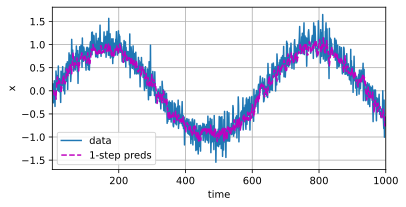

In [6]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

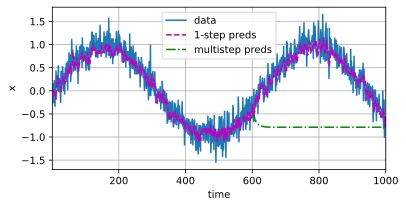

In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))


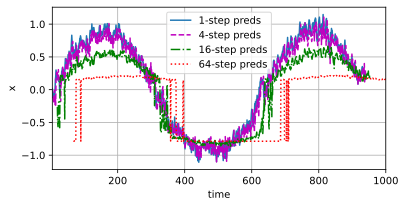

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))

# 2 past observation

epoch 1, loss: 0.084276
epoch 2, loss: 0.070963
epoch 3, loss: 0.065670
epoch 4, loss: 0.063179
epoch 5, loss: 0.060574


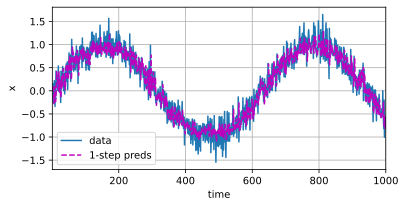

In [9]:
def get_net2():
    net = nn.Sequential(
        nn.Linear(2, 10), 
        nn.ReLU(), 
        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

tau = 2
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

net2 = get_net2()
train(net2, train_iter, loss, 5, 0.01)

onestep_preds = net2(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

# 3 past observation

epoch 1, loss: 0.058840
epoch 2, loss: 0.059412
epoch 3, loss: 0.064637
epoch 4, loss: 0.058239
epoch 5, loss: 0.056169


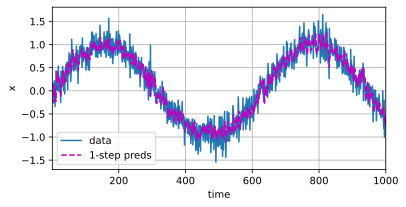

In [10]:
def get_net3():
    net = nn.Sequential(
        nn.Linear(3, 10), 
        nn.ReLU(), 
        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

tau = 3
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

net3 = get_net3()
train(net3, train_iter, loss, 5, 0.01)

onestep_preds = net3(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

# 5 past observation

epoch 1, loss: 0.063132
epoch 2, loss: 0.055296
epoch 3, loss: 0.051693
epoch 4, loss: 0.051515
epoch 5, loss: 0.052605


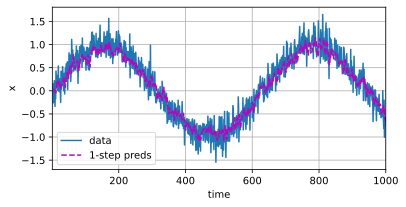

In [11]:
def get_net5():
    net = nn.Sequential(
        nn.Linear(5, 10), 
        nn.ReLU(), 
        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

tau = 5
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

net5 = get_net5()
train(net5, train_iter, loss, 5, 0.01)

onestep_preds = net5(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

# 10 past observation

epoch 1, loss: 0.056775
epoch 2, loss: 0.051059
epoch 3, loss: 0.049918
epoch 4, loss: 0.050518
epoch 5, loss: 0.057105


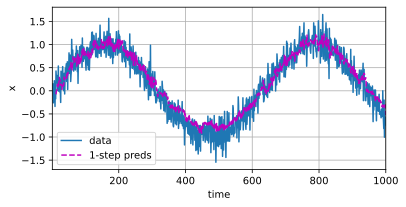

In [12]:
def get_net10():
    net = nn.Sequential(
        nn.Linear(10, 10), 
        nn.ReLU(), 
        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

tau = 10
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

net10 = get_net10()
train(net10, train_iter, loss, 5, 0.01)

onestep_preds = net10(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))